In [1]:
import json
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

from military_grant_funding_exploration.path_functions import get_DoD_DTIC_initial_path
from military_grant_funding_exploration.constants import FUNDER_KEY, FUNDING_AMOUNT_KEY, VIS_FOLDER
from military_grant_funding_exploration.webscraping.functions import parse_int_from_str

In [2]:
def parse_json_as_df(json_filepath):
    with open(json_filepath, "r") as infile_h:
        json_data_all_grants = json.load(infile_h)

    dfs = []
    for json_grant_element in json_data_all_grants:
        # Replace list-typed values with a one-length tuple containing the list, so it can be represented as a single element
        sanitized_json_grant_element = {
            k: ((v,) if isinstance(v, list) else v)
            for k, v in json_grant_element.items()
        }
        # Get rid of commas
        sanitized_json_grant_element["funding_amount_usd"] = parse_int_from_str(sanitized_json_grant_element["funding_amount_usd"])
        df = pd.DataFrame(sanitized_json_grant_element, index=[0])
        dfs.append(df)
    # Change from a list of individual dataframes to a single coherent dataframe
    all_grants_df = pd.concat(dfs)
    for column in all_grants_df.columns:
        all_grants_df[column] = pd.to_numeric(all_grants_df[column], errors="ignore")

    return all_grants_df



In [3]:
CAMPUS = "ucla"

In [4]:
json_path = get_DoD_DTIC_initial_path(CAMPUS)

all_grants_df = parse_json_as_df(json_path)
all_grants_funder_amount = all_grants_df.loc[:, (FUNDER_KEY, "funding_amount_usd")]

all_grants_funder_amount_grouped = all_grants_funder_amount.groupby(by=FUNDER_KEY).sum()
all_grants_funder_amount_grouped.sort_values(by="funding_amount_usd", ascending=False, inplace=True)

C:\Users\david\AppData\Local\Temp\ipykernel_14856\129265449.py:19: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  all_grants_df[column] = pd.to_numeric(all_grants_df[column], errors="ignore")


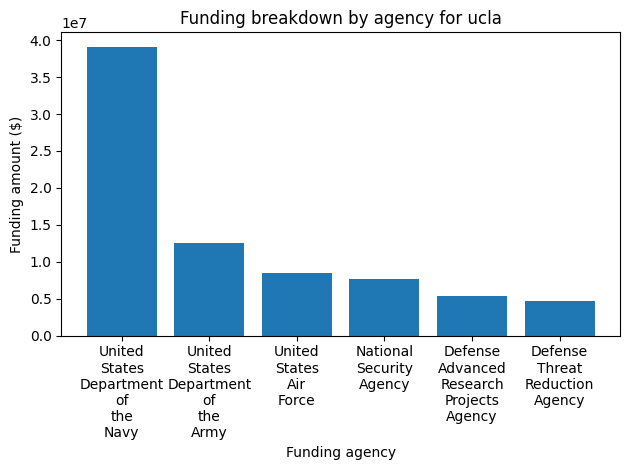

In [5]:
bar_values = all_grants_funder_amount_grouped["funding_amount_usd"].to_list()
bar_labels = all_grants_funder_amount_grouped.index.to_list()
bar_labels = ["\n".join(label.split(" ")) for label in bar_labels]
plt.bar(bar_labels, bar_values)
plt.xlabel("Funding agency")
plt.ylabel("Funding amount ($)")
plt.title(f"Funding breakdown by agency for {CAMPUS}")

output_file = Path(VIS_FOLDER, "funding_per_agency", f"{CAMPUS}_funding_breakdown.png")
output_file.parent.mkdir(exist_ok=True, parents=True)
plt.tight_layout()
plt.savefig(output_file)